In [20]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time

# Load Input Data:

In [21]:
vot_pdf = np.genfromtxt('../original_code/VOT_distr.csv', delimiter=',')[1:]
vots = []
vot_p = []
for row in vot_pdf:
    vots.append(row[0])
    vot_p.append(row[1])
print(vot_p)
print()
vot_p=vot_p/np.sum(vot_p)
print(vot_p)

[0.01, 0.02, 0.01, 0.02, 0.02, 0.02, 0.02, 0.04, 0.02, 0.07, 0.02, 0.07, 0.16, 0.13, 0.05, 0.25, 0.03, 0.05]

[0.00990099 0.01980198 0.00990099 0.01980198 0.01980198 0.01980198
 0.01980198 0.03960396 0.01980198 0.06930693 0.01980198 0.06930693
 0.15841584 0.12871287 0.04950495 0.24752475 0.02970297 0.04950495]


# Travel time functions:

In [22]:
###### BPR Parameters ###### 
bpr_true_capacity = 66
bpr_true_fftt = 60*22/67
bpr_true_alpha = 0.2

def true_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, alpha = bpr_true_alpha):
    """
    Find the (exact) travel time on an edge given an edge flow
    """

    return fftt * (1+alpha*(flow_val/capacity)**6)

###### Approximation Parameters ###### 
const_multiplier = 1
cap_thresh_multiplier = 0.7835
apx_slope = 0.314

def apx_bpr_cost(flow_val, fftt = bpr_true_fftt, capacity = bpr_true_capacity, 
                a = const_multiplier, cap_thresh = cap_thresh_multiplier, b = apx_slope):
    """
    Find the (approximate) travel time on an edge given an edge flow
    """
    
    if flow_val <= cap_thresh*capacity:
        return a*fftt
    else:
        return a*fftt + b*(flow_val - cap_thresh*capacity)

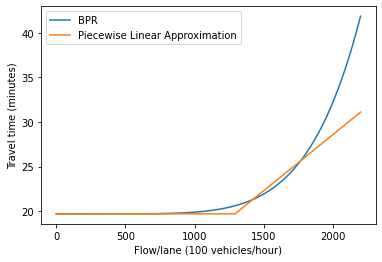

In [23]:
###### Check plots of BPR and approximation ###### 
multiplier = 100/4 # converts from 100 vehicles/hour --> vehicle/hour per lane

x =  np.linspace(0,int(np.round(88*multiplier,0)),int(np.round(89*2*multiplier,0)))
y = [true_bpr_cost(i, capacity = bpr_true_capacity*multiplier) for i in x]

plt.plot(x, y,label='BPR')

y_apx = [apx_bpr_cost(i,capacity = bpr_true_capacity*multiplier, b = apx_slope/multiplier) for i in x]

plt.plot(x, y_apx,label='Piecewise Linear Approximation')
plt.xlabel("Flow/lane (100 vehicles/hour)")
plt.ylabel("Travel time (minutes)")
plt.legend(loc='upper left')

# Generate Demand Profile:

In [24]:
num_eligible_factor = 10.0

###### Specify parameters for problem ###### 
T = 5 # Time Horizon
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
print('Tau:\n {}'.format(tau_arr))
print()

B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 
print('B:\n {}'.format(B_arr))
print()

num_total = 8000 # number of users
num_eligible =int( num_total*.17) # number of eligible users
num_ineligible = num_total-num_eligible # number of ineligible users

###### VoT information ###### 
vot_all = np.sort(np.round(np.random.choice(vots, size = num_total, p=vot_p),2)/60) # generate baseline VoT for all users
vot_all_days = np.empty(shape=(num_total,T)) 
count=0
for v in vot_all:
    if count < num_eligible:
        vot_all_days[count,:]=[v * num_eligible_factor for t in range(T)] # VoT of eligible users does not vary over time periods
    else:
        vot_all_days[count,:]=list((1+0.25*(np.random.random_sample(size=T)-0.5))*v) # VoT of ineligible users varies over time periods
    count+=1
    
vot_eligible = vot_all_days[:num_eligible,:]
vot_ineligible= vot_all_days[num_eligible:,:]

print('Eligible vot range:\n {} ({} $/hr), {} ({} $/hr)'.format(np.min(vot_eligible),60*np.min(np.round(vot_eligible,2)),np.max(np.round(vot_eligible,2)),60*np.max(np.round(vot_eligible,2))))
print()
print('Ineligible vot range:\n {}({} $/hr), {} ({} $/hr)'.format(np.min(np.round(vot_ineligible,2)),60*np.min(np.round(vot_ineligible,2)),np.max(np.round(vot_ineligible,2)),60*np.max(np.round(vot_ineligible,2))))
print()
print('Mean vot:\n {} $/hr; median: {} $/hr'.format(60*np.round(np.mean(vot_all_days),2),60*np.round(np.median(vot_all_days),2)))

Tau:
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

B:
 [ 0.  5. 10. 15. 20. 25. 30. 35. 40. 45. 50. 55. 60. 65. 70. 75. 80. 85.
 90.]

Eligible vot range:
 0.2 (12.0 $/hr), 2.4 (144.0 $/hr)

Ineligible vot range:
 0.21(12.6 $/hr), 2.7 (162.0 $/hr)

Mean vot:
 55.2 $/hr; median: 48.0 $/hr


In [25]:
print("vot_eligible:\n", vot_eligible)
print()
print("vot_ineligible:\n", vot_ineligible)

vot_eligible:
 [[0.2        0.2        0.2        0.2        0.2       ]
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.2        0.2        0.2        0.2        0.2       ]
 ...
 [2.40333333 2.40333333 2.40333333 2.40333333 2.40333333]
 [2.40333333 2.40333333 2.40333333 2.40333333 2.40333333]
 [2.40333333 2.40333333 2.40333333 2.40333333 2.40333333]]

vot_ineligible:
 [[0.22392759 0.25928162 0.26825721 0.23725237 0.22079777]
 [0.24511601 0.25942674 0.24703614 0.22704643 0.22768016]
 [0.26481021 0.21236289 0.21348622 0.27006937 0.22049276]
 ...
 [2.49346397 2.25591821 2.30393712 2.54292573 2.56816765]
 [2.14723714 2.59565566 2.54628009 2.36128778 2.15416672]
 [2.65747712 2.66252064 2.39856906 2.378366   2.46681656]]


Text(0, 0.5, '% of population')

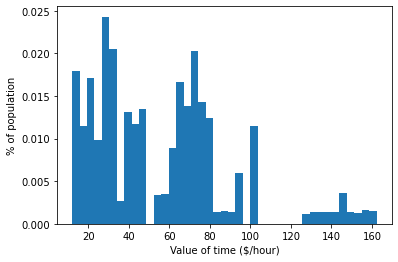

In [26]:
###### Check VoT distribution ###### 
plt.hist(vot_all_days.flatten()*60,bins=41,density=True)
plt.xlabel("Value of time ($/hour)")
plt.ylabel("% of population")

# Define Social Objectives of Interest:

In [27]:
###### Estimate VoT percentiles for ineligible group ###### 

## Frank: Not sure why the percentiles dict was not multiplied by 60 in the previous version of this code.

percentiles = {}
thresh = 10
for p in range(11):
    print(np.round(np.percentile(vot_ineligible,p*10)*60,2))
    percentiles[p*10]=np.percentile(vot_ineligible,p*10)*60

12.62
18.54
23.58
30.06
37.02
43.68
63.22
68.34
74.33
80.15
162.25


In [28]:
print("vot_ineligible:", vot_ineligible)
print()
print("percentiles:", percentiles)

vot_ineligible: [[0.22392759 0.25928162 0.26825721 0.23725237 0.22079777]
 [0.24511601 0.25942674 0.24703614 0.22704643 0.22768016]
 [0.26481021 0.21236289 0.21348622 0.27006937 0.22049276]
 ...
 [2.49346397 2.25591821 2.30393712 2.54292573 2.56816765]
 [2.14723714 2.59565566 2.54628009 2.36128778 2.15416672]
 [2.65747712 2.66252064 2.39856906 2.378366   2.46681656]]

percentiles: {0: 12.617576301088778, 10: 18.543710211186237, 20: 23.583628869548342, 30: 30.05531684341023, 40: 37.01675220993041, 50: 43.68336089678967, 60: 63.21765162428861, 70: 68.33962286945722, 80: 74.333229157283, 90: 80.15284803415912, 100: 162.2525651849492}


# Evaluation Metrics:

In [29]:
###### Evaluate Travel Time Metrics ###### 
def evaluate_avg_tt_in_budget(solution_, demand_multiplier):
    """
    Average travel time, ineligible only
    """
    
    ineligible_tt = sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) * apx_bpr_cost(solution_['edge_flows'][0, t],
                                                                    capacity = bpr_true_capacity * demand_multiplier[0],
                                                                    b = apx_slope / demand_multiplier[0])
                                 for i in range(num_ineligible) for t in range(T))/(T * num_ineligible)
    ineligible_tt += sum( solution_['users_in'][i, 2, t] * apx_bpr_cost(solution_['edge_flows'][1, t],
                                                                    capacity = bpr_true_capacity * demand_multiplier[1],
                                                                    b = apx_slope / demand_multiplier[1])
                                 for i in range(num_ineligible) for t in range(T))/(T * num_ineligible)
    
    
#     print()
#     print("ineligible_total_time:", sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) * apx_bpr_cost(solution_['edge_flows'][0, t],
#                                                                     capacity = bpr_true_capacity * demand_multiplier[0],
#                                                                     b = apx_slope / demand_multiplier[0])
#                                  for i in range(num_ineligible) for t in range(T)) \
#          + sum( solution_['users_in'][i, 2, t] * apx_bpr_cost(solution_['edge_flows'][1, t],
#                                                                     capacity = bpr_true_capacity * demand_multiplier[1],
#                                                                     b = apx_slope / demand_multiplier[1])
#                                  for i in range(num_ineligible) for t in range(T)))
#     print("T:", T)
#     print("num_ineligible:", num_ineligible)
#     print("ineligible_average_time (ineligible_tt):", ineligible_tt)
#     for t in range(T):
#         print("t:", t)
#         print("solution_['edge_flows'][0, t]:", solution_['edge_flows'][0, t])
#         print("solution_['edge_flows'][1, t]:", solution_['edge_flows'][1, t])
#     print()
    
    return ineligible_tt

def evaluate_avg_tt_el_budget(solution_, demand_multiplier):
    """
    Average travel time, eligible only
    """
    
    ## Frank: Not sure why, in the original code, one needs to divide by num_eligible twice.
    # I have removed them for now
    
    # Express lane:
    eligible_tt = sum(( (solution_['users_el'][0, t] + solution_['users_el'][1, t]))*apx_bpr_cost(solution_['edge_flows'][0, t],
                                                               capacity = bpr_true_capacity * demand_multiplier[0],
                                                               b = apx_slope / demand_multiplier[0])
                                for t in range(T)) /(T * num_eligible)
    
    # General-purpose lane:
    eligible_tt += sum((solution_['users_el'][2, t])*apx_bpr_cost(solution_['edge_flows'][1, t],
                                                               capacity = bpr_true_capacity * demand_multiplier[1],
                                                               b = apx_slope / demand_multiplier[1])
                                for t in range(T)) /(T * num_eligible)
    
#     print()
#     print("eligible_total_time:", sum(( (solution_['users_el'][0, t] + solution_['users_el'][1, t]))*apx_bpr_cost(solution_['edge_flows'][0, t],
#                                                                capacity = bpr_true_capacity * demand_multiplier[0],
#                                                                b = apx_slope / demand_multiplier[0])
#                                 for t in range(T)) \
#          + sum((solution_['users_el'][2, t])*apx_bpr_cost(solution_['edge_flows'][1, t],
#                                                                capacity = bpr_true_capacity * demand_multiplier[1],
#                                                                b = apx_slope / demand_multiplier[1])
#                                 for t in range(T)) )
#     print("T:", T)
#     print("num_eligible:", num_eligible)
#     print("eligible_average_time (eligible_tt):", eligible_tt)
#     for t in range(T):
#         print("t:", t)
#         print("solution_['edge_flows'][0, t]:", solution_['edge_flows'][0, t])
#         print("solution_['edge_flows'][1, t]:", solution_['edge_flows'][1, t])
#     print()
    
    return eligible_tt

def evaluate_total_tt_budget(solution_,demand_multiplier):
    """
    Total travel time
    """
    ineligible_tt = evaluate_avg_tt_in_budget(solution_, demand_multiplier) * num_ineligible * T
    eligible_tt = evaluate_avg_tt_el_budget(solution_, demand_multiplier) * num_eligible * T
    
    return eligible_tt + ineligible_tt

def evaluate_avg_travel_time_budget(solution_,demand_multiplier):
    """
    Average travel time
    """
    return evaluate_total_tt_budget(solution_,demand_multiplier)/(T*num_total)

def evaluate_avg_express_tt_budget(solution_,demand_multiplier):
    """
    Average travel time on express lane
    """
    avg_EL_tt = sum(apx_bpr_cost(solution_['edge_flows'][0, t],capacity = bpr_true_capacity*demand_multiplier[0],
                                 b = apx_slope/demand_multiplier[0]) for t in range(T))/T
    return avg_EL_tt

def evaluate_avg_general_tt_budget(solution_,demand_multiplier):
    """
    Average travel time on general purpose lanes
    """
    avg_GP_tt = sum(apx_bpr_cost(solution_['edge_flows'][1, t],capacity = bpr_true_capacity*demand_multiplier[1],
                                 b = apx_slope/demand_multiplier[1]) for t in range(T))/T
    return avg_GP_tt
    
def evaluate_avg_tt_savings_budget(solution_,demand_multiplier):
    """
    Average travel time savings   
    """
    delta_tt = sum(apx_bpr_cost(solution_['edge_flows'][1, t],capacity = bpr_true_capacity*demand_multiplier[1],
                                 b = apx_slope/demand_multiplier[1]) - 
                   apx_bpr_cost(solution_['edge_flows'][0, t],capacity = bpr_true_capacity*demand_multiplier[0],
                                b = apx_slope/demand_multiplier[0]) for t in range(T))/T
    return delta_tt


###### Evaluate Lane Usage Metrics ###### 
def evaluate_express_usage_budget(solution_,demand_multiplier):
    """
    Average share of all/el/inel users using express lane
    """
    share_eligible = sum( (solution_['users_el'][0, t] + solution_['users_el'][1, t]) for t in range(T))/(T * num_eligible)
    share_ineligible = sum((solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t])  for i in range(num_ineligible) for t in range(T))/(T * num_ineligible)
    share_all = (sum(solution_['users_el'][0, t] for t in range(T)) +
               sum(solution_['users_in'][i, 0, t] for i in range(num_ineligible) for t in range(T)) +
                sum(solution_['users_el'][1, t] for t in range(T)) +
               sum(solution_['users_in'][i, 1, t] for i in range(num_ineligible) for t in range(T)) )/(T * num_total)
    
    return share_all, share_eligible, share_ineligible


def evaluate_express_usage_percentile_inel_budget(solution_,demand_multiplier,percentiles):
    share_ineligible = {}
    for p,thresh in percentiles.items():
        # number of ineligible users in the group
        if p >= 10:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0]) for t in range(T))
        else:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60)))[0]) for t in range(T))
        
        share_ineligible[p] = 0
        for t in range(T):
            if p>=10:
                share_ineligible[p]+=sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) 
                                         for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                           (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0])
            else:
                share_ineligible[p]+=sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t])
                                         for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0])
        if these_ineligible > 0:
            share_ineligible[p]=share_ineligible[p]/these_ineligible
#         print("p:", p)
#         print("share_ineligible[p]:", share_ineligible[p])
#         print("these_ineligible:", these_ineligible)
    
    return share_ineligible


###### Evaluate Travel Cost Metrics ###### 
def evaluate_total_travel_cost_in_budget(solution_, tau, demand_multiplier):
    
    """
    Total travel cost for ineligible only
    """
    
    ineligible_travel_cost = sum((solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) * vot_ineligible[i, t]*apx_bpr_cost(solution_['edge_flows'][0, t],
                                                                                                  capacity = bpr_true_capacity*demand_multiplier[0],
                                                                                                  b = apx_slope/demand_multiplier[0])
                                 for i in range(num_ineligible) for t in range(T))
    ineligible_travel_cost += sum(solution_['users_in'][i, 2, t]*vot_ineligible[i, t]*apx_bpr_cost(solution_['edge_flows'][1, t],
                                                                                                  capacity = bpr_true_capacity*demand_multiplier[1],
                                                                                                  b = apx_slope/demand_multiplier[1])
                                 for i in range(num_ineligible) for t in range(T))
    
    toll_revenue_in = evaluate_total_revenue_in_budget(solution_, tau, demand_multiplier)
    return ineligible_travel_cost + toll_revenue_in


def evaluate_total_travel_cost_el_budget(solution_, tau, demand_multiplier):
    
    """
    Total travel cost for eligible only
    """
    
    eligible_travel_cost = sum(( (solution_['users_el'][0, t] + solution_['users_el'][1, t]) /num_eligible)*vot_eligible[i, t]*apx_bpr_cost(solution_['edge_flows'][0, t],
                                                                                                           capacity = bpr_true_capacity*demand_multiplier[0],
                                                                                                           b = apx_slope/demand_multiplier[0])  
                               for i in range(num_eligible) for t in range(T))
    
    eligible_travel_cost += sum((solution_['users_el'][2, t]/num_eligible)*vot_eligible[i, t]*apx_bpr_cost(solution_['edge_flows'][1, t],
                                                                                                           capacity = bpr_true_capacity*demand_multiplier[1],
                                                                                                           b = apx_slope/demand_multiplier[1])  
                               for i in range(num_eligible) for t in range(T))
    
    toll_revenue_el = evaluate_total_revenue_el_budget(solution_, tau, demand_multiplier)
    
    return eligible_travel_cost + toll_revenue_el

def evaluate_total_revenue_in_budget(solution_, tau, demand_multiplier):
    """
    Total toll revenue from ineligible users 
    """
    total_toll_revenue_in = sum(tau * solution_['users_in'][i, 1, t] for i in range(num_ineligible) for t in range(T))
    
    return total_toll_revenue_in

def evaluate_total_revenue_el_budget(solution_, tau, demand_multiplier):
    """
    Total toll revenue from eligible users
    """
    total_toll_revenue_el = sum(tau * solution_['users_el'][1, t] for t in range(T))
    
    return total_toll_revenue_el


def evaluate_total_travel_cost_percentile_inel_budget(solution_,tau,demand_multiplier,percentiles):
    """
    Total travel cost for each ineligible group percentile
    """
    social_cost={}
    for p,thresh in percentiles.items():
        social_cost[p]=0
        for t in range(T):
            if p>=10:
                social_cost[p]+=sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) *vot_ineligible[i, t]*apx_bpr_cost(
                    solution_['edge_flows'][0, t],capacity = bpr_true_capacity*demand_multiplier[0], b = apx_slope/demand_multiplier[0]) 
                                    for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                      (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0])
                
                social_cost[p]+=sum(solution_['users_in'][i, 2, t]*vot_ineligible[i, t]*apx_bpr_cost(
                    solution_['edge_flows'][1, t],capacity = bpr_true_capacity*demand_multiplier[1], b = apx_slope/demand_multiplier[1]) 
                                    for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                      (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0])
                
                social_cost[p]+=sum(solution_['users_in'][i, 1, t]*tau for i in np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                                                         (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0] )
            else:
                social_cost[p]+=sum( (solution_['users_in'][i, 0, t] + solution_['users_in'][i, 1, t]) *vot_ineligible[i, t]*apx_bpr_cost(
                    solution_['edge_flows'][0, t],capacity = bpr_true_capacity*demand_multiplier[0], b = apx_slope/demand_multiplier[0])
                                    for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0])
                social_cost[p]+=sum(solution_['users_in'][i, 2, t]*vot_ineligible[i, t]*apx_bpr_cost(
                    solution_['edge_flows'][1, t],capacity = bpr_true_capacity*demand_multiplier[1], b = apx_slope/demand_multiplier[1])
                                    for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0])
                social_cost[p]+=sum(solution_['users_in'][i, 2, t]*tau for i in np.where((vot_ineligible[:,t]<=(thresh/60)))[0])
    return social_cost

def evaluate_avg_travel_cost_percentile_inel_budget(social_cost_by_percentile):
    """
    Average travel cost for each ineligible group percentile  
    """
    avg_social_cost={}
    for p,thresh in percentiles.items():
        if p >=10:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60))&
                                                (vot_ineligible[:,t]>(percentiles[p-10]/60)))[0]) for t in range(T))
        else:
            these_ineligible = sum(len(np.where((vot_ineligible[:,t]<=(thresh/60)))[0]) for t in range(T))
        if these_ineligible>0:
            avg_social_cost[p]=social_cost_by_percentile[p]/these_ineligible
        else:
            avg_social_cost[p]=0
    return avg_social_cost

In [30]:
def to_str(num):
    num = int(num)
    
    # For any number < 100:
    if num < 10:
        return str(0) + str(num)
    else:
        return str(num)

# Plots:

## Case 1 - Budget:

In [31]:
# tau_arr = 20 * np.linspace(0, 1, 21)[0:]
# B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) 

# print("tau_arr:\n", tau_arr)
# print()
# print("B_arr:\n", B_arr)

In [32]:
T = 5
tau_arr = 20 * np.linspace(0, 1, 11)[0:]
B_arr = np.linspace(tau_arr[0], tau_arr[-1]*4, 9)

print("tau_arr:\n", tau_arr)
print()
print("B_arr:\n", B_arr)

tau_arr:
 [ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20.]

B_arr:
 [ 0. 10. 20. 30. 40. 50. 60. 70. 80.]


In [33]:
path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data/data_budget/"
file_name = path_directory + "toll_20_budget_60.csv"
data_df = pd.read_csv(file_name, sep=',', index_col=0)
data_df
# data = data_df.to_numpy()

,"Monday, Express (Credit)","Monday, Express (Paying)","Monday, General Purpose","Tuesday, Express (Credit)","Tuesday, Express (Paying)","Tuesday, General Purpose","Wednesday, Express (Credit)","Wednesday, Express (Paying)","Wednesday, General Purpose","Thursday, Express (Credit)","Thursday, Express (Paying)","Thursday, General Purpose","Friday, Express (Credit)","Friday, Express (Paying)","Friday, General Purpose"
Edge flows,0.0,1.192000e+03,6.808000e+03,0.0,1.192000e+03,6.808000e+03,0.0,1.192000e+03,6.808000e+03,0.0,1.192000e+03,6.808000e+03,0.0,1.192000e+03,6.808000e+03
Eps flows,0.0,3.729778e-02,2.929675e+03,0.0,3.727613e-02,2.929675e+03,0.0,3.728268e-02,2.929675e+03,0.0,3.728055e-02,2.929675e+03,0.0,3.726209e-02,2.929675e+03
Eligible User Flows,816.0,1.668779e-12,5.440000e+02,816.0,1.668779e-12,5.440000e+02,816.0,1.668779e-12,5.440000e+02,816.0,1.668779e-12,5.440000e+02,816.0,1.668779e-12,5.440000e+02
"Ineligible User Flow, 1",0.0,1.905698e-12,1.000000e+00,0.0,1.864953e-12,1.000000e+00,0.0,1.565970e-12,1.000000e+00,0.0,1.694311e-12,1.000000e+00,0.0,1.502576e-12,1.000000e+00
"Ineligible User Flow, 2",0.0,1.698752e-12,1.000000e+00,0.0,1.775802e-12,1.000000e+00,0.0,1.834644e-12,1.000000e+00,0.0,1.587064e-12,1.000000e+00,0.0,1.741052e-12,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Ineligible User Flow, 6636",0.0,1.000000e+00,2.955748e-11,0.0,1.000000e+00,2.742152e-11,0.0,1.000000e+00,2.623451e-11,0.0,1.000000e+00,2.871655e-11,0.0,1.000000e+00,2.975631e-11
"Ineligible User Flow, 6637",0.0,1.000000e+00,3.001308e-11,0.0,1.000000e+00,2.846479e-11,0.0,1.000000e+00,4.286032e-11,0.0,1.000000e+00,2.743366e-11,0.0,1.000000e+00,3.348792e-11
"Ineligible User Flow, 6638",0.0,1.000000e+00,2.977410e-11,0.0,1.000000e+00,2.854493e-11,0.0,1.000000e+00,3.123097e-11,0.0,1.000000e+00,3.867360e-11,0.0,1.000000e+00,3.656146e-11
"Ineligible User Flow, 6639",0.0,1.000000e+00,4.332118e-11,0.0,1.000000e+00,3.367903e-11,0.0,1.000000e+00,3.149519e-11,0.0,1.000000e+00,2.549021e-11,0.0,1.000000e+00,3.158432e-11


In [36]:
t_1 = time.time()

demand_multiplier = [25, 75]

# # For retrieving data:

row_names = ["Edge flows", "Eps flows", "Eligible User Flows"]
row_names += ["Ineligible User Flow, " + str(k) for k in list(range(num_ineligible + 1))[1:]]

column_names = []
workday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
lane_names = ["Express (Credit)", "Express (Paying)", "General Purpose"]
for workday_index, workday in enumerate(workday_names):
    for lane_index, lane in enumerate(lane_names):
        column_names.append(workday + ", " + lane)


#
tau_arr = 20*np.linspace(0, 1, 21)[0:] # Toll discretization
B_arr = np.linspace(tau_arr[0], tau_arr[-3]*T,19) # Budget discretization 

## For debugging purposes, truncate tau_arr and B_arr:
# tau_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# B_arr = [0.0, 5.0, 10.0, 15.0, 20.0]
# tau_arr = 20 * np.linspace(0, 1, 11)[0:] 
# B_arr = np.linspace(tau_arr[0], tau_arr[-1]*4, 9)
# tau_arr = [2.0]
# B_arr = [0.0]

###### Initialize matrices for results ###### 
# Optimization problems are iterated over tolls budgets

avg_tt_in_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_el_budget = np.zeros((len(tau_arr), len(B_arr)))
total_tt_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_EL_tt_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_GP_tt_budget = np.zeros((len(tau_arr), len(B_arr)))
avg_tt_savings_budget = np.zeros((len(tau_arr), len(B_arr)))

exp_all_budget = np.zeros((len(tau_arr), len(B_arr)))
exp_el_budget = np.zeros((len(tau_arr), len(B_arr)))
exp_in_budget = np.zeros((len(tau_arr), len(B_arr)))
exp_in_p_budget = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}

total_tc_in_budget = np.zeros((len(tau_arr), len(B_arr)))
total_tc_el_budget = np.zeros((len(tau_arr), len(B_arr)))
total_tr_budget = np.zeros((len(tau_arr), len(B_arr)))
total_tc_in_p_budget = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}
avg_tc_in_p_budget = {10*p:np.zeros((len(tau_arr),len(B_arr))) for p in range(11)}


total_count = len(tau_arr) * len(B_arr)

for toll_idx, toll in enumerate(tau_arr):    
    for budget_idx, budget in enumerate(B_arr):
        
#         if budget >= toll * T or budget == 0 or toll == 0:
#             continue
        
        print()
        print("Toll:", toll)
        print("Budget:", budget)
        print()

        # For retrieving data:
        if num_eligible_factor != 1.0 and 0.0 < budget < toll * T:
            path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data/data_budget_" + str(int(num_eligible_factor)) + "x/"
        else:
            path_directory = "/Users/chih-yuanchiu/Desktop/Code/CBCP_Credit_Discount/data/data_budget/"
    
        file_name = path_directory + "toll_" + to_str(toll) + "_budget_" + to_str(budget) + ".csv"
        
        data_df = pd.read_csv(file_name, sep = ',', index_col=0)
        data = data_df.to_numpy()
        num_ineligible_in_data = data.shape[0] - 3
        
        # Reconstruct solution set:
        solution_set = {}
        solution_set["edge_flows"] = data[0, :].reshape((5, 3))[:, 1:].T
        solution_set["eps_flows"] = data[1, :].reshape((5, 3))[:, 1:].T
        solution_set["users_el"] = data[2, :].reshape((5, 3)).T
        solution_set["users_in"] = data[3:,].reshape((num_ineligible_in_data, 5, 3)).transpose((0, 2, 1))
        
        avg_tt_in_budget[toll_idx, budget_idx] = evaluate_avg_tt_in_budget(solution_set, demand_multiplier)
        avg_tt_el_budget[toll_idx, budget_idx] = evaluate_avg_tt_el_budget(solution_set, demand_multiplier)
        total_tt_budget[toll_idx, budget_idx] = evaluate_total_tt_budget(solution_set,demand_multiplier)
        avg_tt_budget[toll_idx, budget_idx] = evaluate_avg_travel_time_budget(solution_set,demand_multiplier)
        avg_EL_tt_budget[toll_idx, budget_idx] = evaluate_avg_express_tt_budget(solution_set,demand_multiplier)
        avg_GP_tt_budget[toll_idx, budget_idx] = evaluate_avg_general_tt_budget(solution_set,demand_multiplier)
        avg_tt_savings_budget[toll_idx, budget_idx] = evaluate_avg_tt_savings_budget(solution_set,demand_multiplier)

        exp_all_budget[toll_idx, budget_idx], exp_el_budget[toll_idx, budget_idx], exp_in_budget[toll_idx, budget_idx] \
            = evaluate_express_usage_budget(solution_set,demand_multiplier)

        total_tc_in_budget[toll_idx, budget_idx] = evaluate_total_travel_cost_in_budget(solution_set, toll, demand_multiplier)
        total_tc_el_budget[toll_idx, budget_idx] = evaluate_total_travel_cost_el_budget(solution_set, toll, demand_multiplier)
        total_tr_budget[toll_idx, budget_idx] = evaluate_total_revenue_in_budget(solution_set, toll, demand_multiplier) \
            + evaluate_total_revenue_el_budget(solution_set, toll, demand_multiplier)
        
        share_inel_all_budget = evaluate_express_usage_percentile_inel_budget(solution_set,demand_multiplier,percentiles)
        total_social_cost_inel_all_budget = evaluate_total_travel_cost_percentile_inel_budget(solution_set,toll,demand_multiplier,percentiles)
        avg_social_cost_inel_all_budget = evaluate_avg_travel_cost_percentile_inel_budget(total_social_cost_inel_all_budget)
        for p in range(11):
            exp_in_p_budget[p*10][toll_idx,budget_idx] = share_inel_all_budget[p*10]
            total_tc_in_p_budget[p*10][toll_idx,budget_idx] = total_social_cost_inel_all_budget[p*10]
            avg_tc_in_p_budget[p*10][toll_idx,budget_idx] = avg_social_cost_inel_all_budget[p*10]

t_2 = time.time()
print("Run time:", t_2 - t_1)


Toll: 0.0
Budget: 0.0


Toll: 0.0
Budget: 5.0


Toll: 0.0
Budget: 10.0


Toll: 0.0
Budget: 15.0


Toll: 0.0
Budget: 20.0


Toll: 0.0
Budget: 25.0


Toll: 0.0
Budget: 30.0


Toll: 0.0
Budget: 35.0


Toll: 0.0
Budget: 40.0


Toll: 0.0
Budget: 45.0


Toll: 0.0
Budget: 50.0


Toll: 0.0
Budget: 55.0


Toll: 0.0
Budget: 60.0


Toll: 0.0
Budget: 65.0


Toll: 0.0
Budget: 70.0


Toll: 0.0
Budget: 75.0


Toll: 0.0
Budget: 80.0


Toll: 0.0
Budget: 85.0


Toll: 0.0
Budget: 90.0


Toll: 1.0
Budget: 0.0


Toll: 1.0
Budget: 5.0


Toll: 1.0
Budget: 10.0


Toll: 1.0
Budget: 15.0


Toll: 1.0
Budget: 20.0


Toll: 1.0
Budget: 25.0


Toll: 1.0
Budget: 30.0


Toll: 1.0
Budget: 35.0


Toll: 1.0
Budget: 40.0


Toll: 1.0
Budget: 45.0


Toll: 1.0
Budget: 50.0


Toll: 1.0
Budget: 55.0


Toll: 1.0
Budget: 60.0


Toll: 1.0
Budget: 65.0


Toll: 1.0
Budget: 70.0


Toll: 1.0
Budget: 75.0


Toll: 1.0
Budget: 80.0


Toll: 1.0
Budget: 85.0


Toll: 1.0
Budget: 90.0


Toll: 2.0
Budget: 0.0


Toll: 2.0
Budget: 5.0


Toll:


Toll: 14.000000000000002
Budget: 55.0


Toll: 14.000000000000002
Budget: 60.0


Toll: 14.000000000000002
Budget: 65.0


Toll: 14.000000000000002
Budget: 70.0


Toll: 14.000000000000002
Budget: 75.0


Toll: 14.000000000000002
Budget: 80.0


Toll: 14.000000000000002
Budget: 85.0


Toll: 14.000000000000002
Budget: 90.0


Toll: 15.0
Budget: 0.0


Toll: 15.0
Budget: 5.0


Toll: 15.0
Budget: 10.0


Toll: 15.0
Budget: 15.0


Toll: 15.0
Budget: 20.0


Toll: 15.0
Budget: 25.0


Toll: 15.0
Budget: 30.0


Toll: 15.0
Budget: 35.0


Toll: 15.0
Budget: 40.0


Toll: 15.0
Budget: 45.0


Toll: 15.0
Budget: 50.0


Toll: 15.0
Budget: 55.0


Toll: 15.0
Budget: 60.0


Toll: 15.0
Budget: 65.0


Toll: 15.0
Budget: 70.0


Toll: 15.0
Budget: 75.0


Toll: 15.0
Budget: 80.0


Toll: 15.0
Budget: 85.0


Toll: 15.0
Budget: 90.0


Toll: 16.0
Budget: 0.0


Toll: 16.0
Budget: 5.0


Toll: 16.0
Budget: 10.0


Toll: 16.0
Budget: 15.0


Toll: 16.0
Budget: 20.0


Toll: 16.0
Budget: 25.0


Toll: 16.0
Budget: 30.0


Toll: 1

In [37]:
# print("num_total:", num_total)
# print("num_eligible:", num_eligible)
# print("num_ineligible:", num_ineligible)
# print("toll:", toll)
# print("budget:", budget)
# print("num_eligible:", num_eligible)
# print("num_ineligible_trunc:", num_ineligible_trunc)
# print("vot_ineligible:", vot_ineligible)
# print("alpha:", bpr_true_alpha)
# print("fftt_1:", bpr_true_fftt)
# print("fftt_2:", bpr_true_fftt)
# print("c_1:", bpr_true_capacity*demand_multiplier[0])
# print("c_2:", bpr_true_capacity*demand_multiplier[1])
# print("a:", const_multiplier)
# print("cap_thresh:", cap_thresh_multiplier)
# print("b_1:", apx_slope/demand_multiplier[0])
# print("b_2:", apx_slope/demand_multiplier[1])
# print()



In [38]:
print(solution_set["edge_flows"])
print()
print(solution_set["eps_flows"])
print()
print(solution_set["users_el"])

[[1484.85075013 1484.85075013 1484.85075013 1484.85075013 1484.85075013]
 [6515.14924988 6515.14924987 6515.14924987 6515.14924988 6515.14924987]]

[[ 192.07575013  192.07575013  192.07575013  192.07575013  192.07575013]
 [2636.82424988 2636.82424987 2636.82424987 2636.82424988 2636.82424987]]

[[1.22285075e+03 1.21359700e+03 1.21885075e+03 1.23885075e+03
  1.22585075e+03]
 [5.90554259e-11 5.90569949e-11 5.90559836e-11 5.90561703e-11
  5.90557973e-11]
 [1.37149246e+02 1.46403004e+02 1.41149250e+02 1.21149250e+02
  1.34149250e+02]]


# Plotting:

In [39]:
from mpl_toolkits.mplot3d import Axes3D

def side_by_side_figs(x,y,z_list,x_lab,y_lab,z_lab_list,filename,dimensions='3d',dim_range = None, textSize=18, \
                     min_val_specified = None, max_val_specified = None):
    """
    Produce and save heatmap plots; either 3D or 2D
    Can produce up to 4 plots side-by-side with same color scale
    ** all final plots in paper were flat 2D: dimensions='2df'
    """
    plt.rc('font', size=textSize) #controls default text size
    plt.rc('axes', titlesize=textSize) #fontsize of the axes title
    plt.rc('axes', labelsize=textSize) #fontsize of the x and y labels
    plt.rc('xtick', labelsize=textSize) #fontsize of the x tick labels
    plt.rc('ytick', labelsize=textSize) #fontsize of the y tick labels
    plt.rc('legend', fontsize=textSize) #fontsize of the legend
    
    if len(z_list)==1:
        ax_1=111
    elif len(z_list)==2:
        ax_1=121
        ax_2=122
    elif len(z_list)==3:
        ax_1=131
        ax_2=132
        ax_3=133
    else:
        ax_1=141
        ax_2=142
        ax_3=143
        ax_4=144
    mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    mappable.set_array(z_list[0])
    
    min_val=min([z.min() for z in z_list])
    max_val=max([z.max() for z in z_list])
    
    if min_val_specified != None:
        min_val = min_val_specified
    if max_val_specified != None:
        max_val = max_val_specified
    
    if dim_range is not None:
         mappable.set_clim(dim_range[0],dim_range[1]) # optional
    else:
        mappable.set_clim(min_val,max_val) # optional

    fig = plt.figure(figsize=(7*len(z_list),7))
    
    if dimensions !='2df':
        ax1 = fig.add_subplot(ax_1, projection='3d')
        ax1.plot_surface(x,y,z_list[0], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
    else:
        ax1 = fig.add_subplot(ax_1)
        ax1.imshow(z_list[0],extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=1/5,origin='lower',vmin=min_val, vmax=max_val)
    
    if dimensions=='2d':
        ax1.view_init(90,270)
        cb = fig.colorbar(mappable,ax=ax1, shrink=0.5) #, aspect=5
        cb.set_label(z_lab_list[0], fontsize=textSize)
    elif dimensions =='2df':
        cb = fig.colorbar(mappable, shrink=0.7) #, aspect=5
        cb.set_label(z_lab_list[0], fontsize=textSize)
        plt.rcParams.update({'font.size': textSize})
    else:
        ax1.set_zlabel(z_lab_list[0], fontsize=textSize)
    if dimensions !='2df':
        ax1.set_xlabel(x_lab, fontsize=textSize)
        ax1.set_ylabel(y_lab, fontsize=textSize)
    else:
        plt.xlabel(x_lab)
        plt.ylabel(y_lab)
        
    if len(z_list)>1:
        if dimensions !='2df':
            ax2 = fig.add_subplot(ax_2, projection='3d')
            ax2.plot_surface(x,y,z_list[1], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
        else:
            ax2 = fig.add_subplot(ax_2)
            ax2.imshow(z_list[1],extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=1/5,origin='lower',vmin=min_val, vmax=max_val)
        if dimensions=='2d':
            ax2.view_init(90,270)
            cb = fig.colorbar(mappable,ax=ax2, shrink=0.5) #, aspect=5
            cb.set_label(z_lab_list[1], fontsize=textSize)
        elif dimensions =='2df':
            cb = fig.colorbar(mappable, shrink=0.7) #, aspect=5
            cb.set_label(z_lab_list[1], fontsize=12)
            plt.rcParams.update({'font.size': textSize})
        else:
            ax2.set_zlabel(z_lab_list[1], fontsize=textSize)
        ax2.set_xlabel(x_lab, fontsize=textSize)
        ax2.set_ylabel(y_lab, fontsize=textSize)
            
    if len(z_list)>2:
        if dimensions !='2df':
            ax3 = fig.add_subplot(ax_3, projection='3d')
            ax3.plot_surface(x,y,z_list[2], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
        else:
            ax3 = fig.add_subplot(ax_3)
            ax3.imshow(z_list[2],extent=[np.min(x),np.max(x),np.min(y),np.max(y)],aspect=1/5,origin='lower',vmin=min_val, vmax=max_val)

        if dimensions=='2d':
            ax3.view_init(90,270)
            cb = fig.colorbar(mappable,ax=ax3, shrink=0.5) #, aspect=5
            cb.set_label(z_lab_list[2], fontsize=textSize)
        elif dimensions =='2df':
            cb = fig.colorbar(mappable, shrink=0.7) #, aspect=5
            cb.set_label(z_lab_list[2], fontsize=textSize)
            plt.rcParams.update({'font.size': textSize})
        else:
            ax3.set_zlabel(z_lab_list[2], fontsize=textSize)
        ax3.set_xlabel(x_lab, fontsize=textSize)
        ax3.set_ylabel(y_lab, fontsize=textSize)
        
    if len(z_list)>3:
        ax4 = fig.add_subplot(ax_4, projection='3d')
        ax4.plot_surface(x,y,z_list[3], cmap=mappable.cmap, norm=mappable.norm, linewidth=0, antialiased=False)
        if dimensions=='2d':
            ax4.view_init(90,270)
        ax4.set_xlabel(x_lab, fontsize=textSize)
        ax4.set_ylabel(y_lab, fontsize=textSize)
        ax4.set_zlabel(z_lab_list[3], fontsize=textSize)
    
    plt.savefig('../plots/plots_budget/{}_budget.png'.format(filename),bbox_inches='tight')

In [40]:
# exp_el_budget

In [41]:
tau_arr_for_plot = 20*np.linspace(0, 1, 21)[0:]
B_arr_for_plot = np.linspace(tau_arr[0], tau_arr[-3]*T,19)

# tau_arr_for_plot = 20 * np.linspace(0, 1, 11)[0:] 
# B_arr_for_plot = np.linspace(tau_arr[0], tau_arr[-1]*4, 9)

x_plot, y_plot = np.meshgrid(tau_arr_for_plot, B_arr_for_plot) # prepare x,y axes

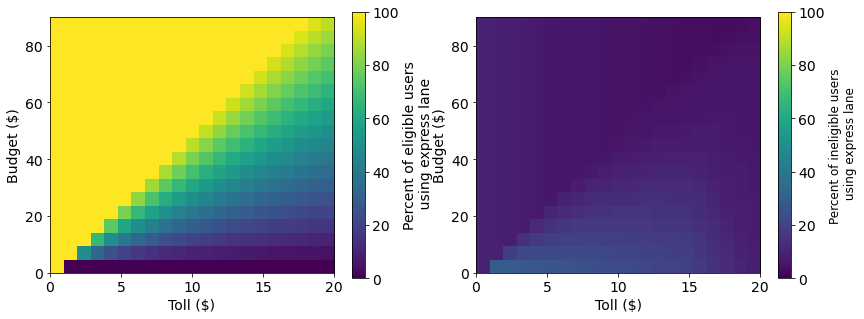

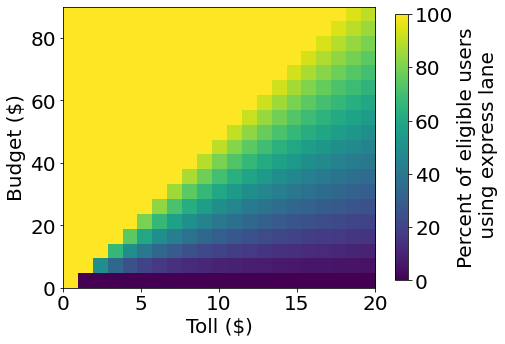

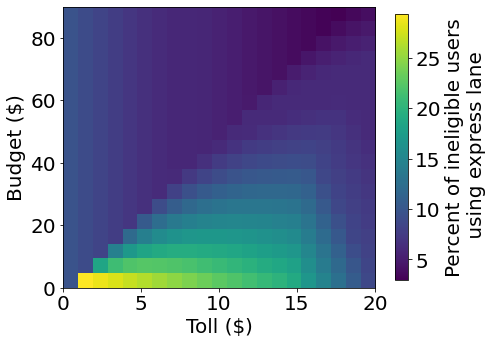

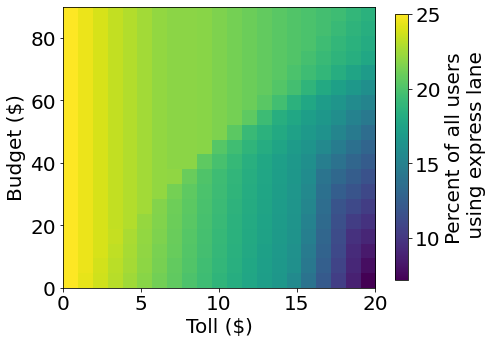

In [42]:
###### Fractions of users on the express lane ######
side_by_side_figs(x_plot,y_plot,[100*exp_el_budget.T, 100*exp_in_budget.T],'Toll ($)','Budget ($)',
                  ["Percent of eligible users\n using express lane","Percent of ineligible users\n using express lane"],
                  'ExpressSharesELIN_2d',dimensions='2df',textSize=14)
side_by_side_figs(x_plot,y_plot,[100*exp_el_budget.T],'Toll ($)','Budget ($)',
                  ["Percent of eligible users\n using express lane"],'ExpressSharesEL_2d',dimensions='2df',textSize=20)
side_by_side_figs(x_plot,y_plot,[100*exp_in_budget.T],'Toll ($)','Budget ($)',
                  ["Percent of ineligible users\n using express lane"],'ExpressSharesIN_2d',dimensions='2df',textSize=20)
side_by_side_figs(x_plot,y_plot,[100*exp_all_budget.T],'Toll ($)','Budget ($)',
                  ["Percent of all users\n using express lane"],'ExpressShareAll_2d',dimensions='2df',textSize=20)

In [43]:
# share_inel_all_budget
# exp_in_p_budget

In [44]:
print("num_eligible:", num_eligible)
print("num_ineligible:", num_ineligible)

num_eligible: 1360
num_ineligible: 6640


In [32]:
# ###### Fractions of ineligible users on the express lane by decile ######
# for p in range(1,11):
#     side_by_side_figs(x_plot,y_plot,[100*exp_in_p_budget[10*p].T],'Toll','Budget',
#                   ["Percent of the {}th decile\nof ineligible users\n using express lane".format(p)],'ExpressSharesINP{}_2d'.format(p),dimensions='2df')

In [22]:
# print(avg_tt_budget)
# print()
# print(avg_EL_tt_budget)
# print()
# print(avg_GP_tt_budget)

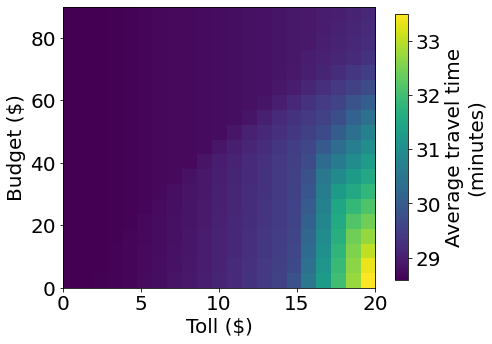

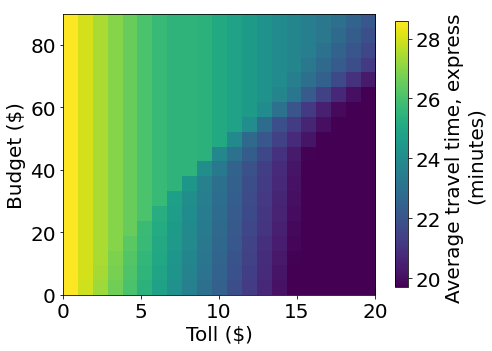

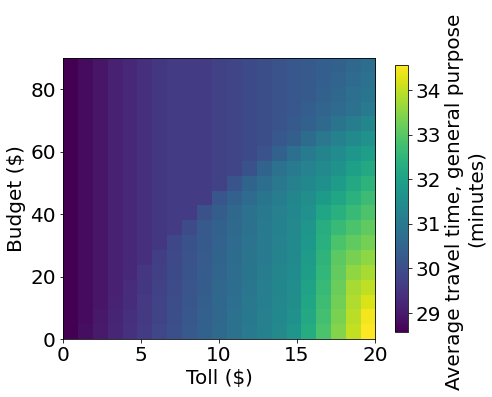

In [35]:
###### Average travel times ######
# side_by_side_figs(x_plot,y_plot,[avg_tt_budget.T],'Toll ($)','Budget ($)',
#                   ["Average travel time\n(minutes)"],'Avg_TravelTime_2d',dimensions='2df',textSize=20)
# side_by_side_figs(x_plot,y_plot,[avg_EL_tt_budget.T],'Toll ($)','Budget ($)',
#                   ["Average travel time, eligible \n(minutes)"],'AvgTravelTimesE_2d',dimensions='2df',textSize=20)
# side_by_side_figs(x_plot,y_plot,[avg_GP_tt_budget.T],'Toll ($)','Budget ($)',
#                   ["Average travel time, ineligible \n(minutes)"],'AvgTravelTimesNE_2d',dimensions='2df',textSize=20)

# min_val_specified = 20
# max_val_specified = 35

# min_val_specified = None
# max_val_specified = None

side_by_side_figs(x_plot,y_plot,[avg_tt_budget.T],'Toll ($)','Budget ($)',
                  ["Average travel time\n(minutes)"],'Avg_TravelTime_2d',dimensions='2df',textSize=20, \
                  min_val_specified = None, max_val_specified = None)
# side_by_side_figs(x_plot,y_plot,[avg_tt_el_budget.T],'Toll ($)','Budget ($)',
#                   ["Average travel time, eligible \n(minutes)"],'AvgTravelTimesE_2d',dimensions='2df',textSize=20, \
#                   min_val_specified = None, max_val_specified = None)
# side_by_side_figs(x_plot,y_plot,[avg_tt_in_budget.T],'Toll ($)','Budget ($)',
#                   ["Average travel time, ineligible \n(minutes)"],'AvgTravelTimesNE_2d',dimensions='2df',textSize=20, \
#                   min_val_specified = None, max_val_specified = None)
side_by_side_figs(x_plot,y_plot,[avg_EL_tt_budget.T],'Toll ($)','Budget ($)',
                  ["Average travel time, express \n(minutes)"],'AvgTravelTimesNE_2d',dimensions='2df',textSize=20, \
                  min_val_specified = None, max_val_specified = None)
side_by_side_figs(x_plot,y_plot,[avg_GP_tt_budget.T],'Toll ($)','Budget ($)',
                  ["Average travel time, general purpose \n(minutes)"],'AvgTravelTimesE_2d',dimensions='2df',textSize=20, \
                  min_val_specified = None, max_val_specified = None)

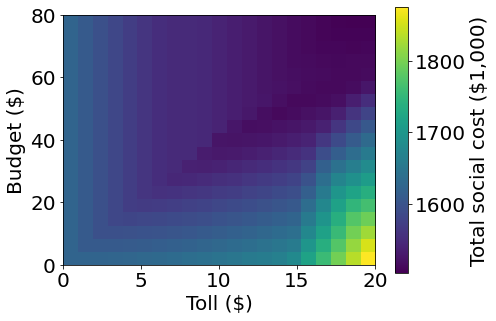

In [42]:
###### Pareto-weighted objective functions ######
weight_e = 35
weight_i = 1
weight_t = 1
z_labels={"1_0_0":"Total travel cost ($1,000)\nEligible users",
         "0_1_0":"Total travel cost ($1,000)\nIneligible users",
         "0_0_1":"Negative total toll revenue\n($1,000)",
         "1_1_1":"Total social cost ($1,000)",
         "5_1_1":"Total social cost ($1,000)",
          "10_1_1":"Total social cost ($1,000)",
         "11_1_1":"Total social cost ($1,000)",
         "12_1_1":"Total social cost ($1,000)",
         "15_1_1":"Total social cost ($1,000)","35_1_1":"Total social cost ($1,000)"}
side_by_side_figs(x_plot,y_plot,[((weight_i*total_tc_in_budget.T)+(weight_e*total_tc_el_budget.T)-(weight_t*total_tr_budget.T))/1000],
                  'Toll ($)','Budget ($)',[z_labels["{}_{}_{}".format(weight_e,weight_i,weight_t)]],
                  'Total SWEL{}IN{}_TR{}_2d'.format(weight_e,weight_i,weight_t),dimensions='2df',textSize=20)

In [49]:
###### Compute optimal CBCP & metrics for various weigthing schemes ######
t_ix=0
b_ix=0
t=int(tau_arr[t_ix])
b=int(B_arr[b_ix])
weight_e = 1
weight_i = 1
weight_t = 1

this_df = []

for weight_e in range(21):
    for i in range(len(tau_arr)):
        this_row={'weight_e':weight_e,'weight_i':weight_i,'weight_t':weight_t}
        this=np.where(((weight_i*total_tc_in_budget[i])+(weight_e*total_tc_el_budget[i])-(weight_t*total_tr_budget[i]))==np.min(
                        ((weight_i*total_tc_in_budget)+(weight_e*total_tc_el_budget)-(weight_t*total_tr_budget))))[0]
        t=int(tau_arr[i])
        
#         print("quantities for determining this:\n", (weight_i*total_tc_in_budget)+(weight_e*total_tc_el_budget)-(weight_t*total_tr_budget))
#         print()
#         print("weight_e:", weight_e)
#         print("i", i)
        
        if len(this)>0:
#             print("weight_e:", weight_e)
#             print("i:", i)
#             print("t:", t)
#             print("this:", this)
#             print()
            
            b=int(B_arr[this[0]])
            this_row['toll']=t
            this_row['budget']=b
            t_ix=i
            b_ix=this[0]
            this_row['ExpShare_All']=np.round(100*exp_all_budget[t_ix,b_ix],0)
            this_row['ExpShare_El']=np.round(100*exp_el_budget[t_ix,b_ix],0)
            this_row['ExpShare_In']=np.round(100*exp_in_budget[t_ix,b_ix],0)
            this_row['TotalGenCost_All']=np.round((total_tc_in_budget[t_ix,b_ix]+total_tc_el_budget[t_ix,b_ix]+total_tr_budget[t_ix,b_ix]),2)
            this_row['TotalGenCost_El']=np.round(total_tc_el_budget[t_ix,b_ix],2)
            this_row['TotalGenCost_In']=np.round(total_tc_in_budget[t_ix,b_ix],2)
            this_row['TotalTR']=np.round(total_tr_budget[t_ix,b_ix],2)
            this_row['AvgTT_Express']=np.round(avg_EL_tt_budget[t_ix,b_ix],1)
            this_row['AvgTT_GP']=np.round(avg_GP_tt_budget[t_ix,b_ix],1)
            this_df.append(this_row)
            
for s in [[1,0,0],[0,1,0],[0,0,1]]:
    weight_e = s[0]
    weight_i = s[1]
    weight_t = s[2]
    for i in range(len(tau_arr)):
        this_row={'weight_e':weight_e,'weight_i':weight_i,'weight_t':weight_t}
        this=np.where(((weight_i*total_tc_in_budget[i])+(weight_e*total_tc_el_budget[i])-(weight_t*total_tr_budget[i]))==np.min(
                        ((weight_i*total_tc_in_budget)+(weight_e*total_tc_el_budget)-(weight_t*total_tr_budget))))[0]
        t=int(tau_arr[i])
        if len(this)>0:
            b=int(B_arr[this[0]])
            this_row['toll']=t
            this_row['budget']=b
            t_ix=i
            b_ix=this[0]
            this_row['ExpShare_All']=np.round(100*exp_all_budget[t_ix,b_ix],0)
            this_row['ExpShare_El']=np.round(100*exp_el_budget[t_ix,b_ix],0)
            this_row['ExpShare_In']=np.round(100*exp_in_budget[t_ix,b_ix],0)
            this_row['TotalGenCost_All']=np.round((total_tc_in_budget[t_ix,b_ix]+total_tc_el_budget[t_ix,b_ix]+total_tr_budget[t_ix,b_ix]),2)
            this_row['TotalGenCost_El']=np.round(total_tc_el_budget[t_ix,b_ix],2)
            this_row['TotalGenCost_In']=np.round(total_tc_in_budget[t_ix,b_ix],2)
            this_row['TotalTR']=np.round(total_tr_budget[t_ix,b_ix],2)
            this_row['AvgTT_Express']=np.round(avg_EL_tt_budget[t_ix,b_ix],1)
            this_row['AvgTT_GP']=np.round(avg_GP_tt_budget[t_ix,b_ix],1)
            this_df.append(this_row)

this_df=pd.DataFrame.from_records(this_df)
this_df

,weight_e,weight_i,weight_t,toll,budget,ExpShare_All,ExpShare_El,ExpShare_In,TotalGenCost_All,TotalGenCost_El,TotalGenCost_In,TotalTR,AvgTT_Express,AvgTT_GP
0,0,1,1,12,0,18.0,0.0,21.0,986218.52,24656.98,876546.48,85015.06,21.3,31.0
1,1,1,1,12,0,18.0,0.0,21.0,986218.52,24656.98,876546.48,85015.06,21.3,31.0
2,2,1,1,12,0,18.0,0.0,21.0,986218.52,24656.98,876546.48,85015.06,21.3,31.0
3,3,1,1,11,0,18.0,0.0,22.0,977313.53,24505.16,872368.34,80440.02,21.8,30.8
4,4,1,1,11,0,18.0,0.0,22.0,977313.53,24505.16,872368.34,80440.02,21.8,30.8
5,5,1,1,11,0,18.0,0.0,22.0,977313.53,24505.16,872368.34,80440.02,21.8,30.8
6,6,1,1,10,0,19.0,0.0,23.0,967979.79,24351.31,868189.26,75439.23,22.4,30.6
7,7,1,1,10,0,19.0,0.0,23.0,967979.79,24351.31,868189.26,75439.23,22.4,30.6
8,8,1,1,10,0,19.0,0.0,23.0,967979.79,24351.31,868189.26,75439.23,22.4,30.6
9,9,1,1,9,0,19.0,0.0,23.0,958164.74,24197.44,863991.02,69976.28,23.0,30.4


In [44]:
# total_tc_in_budget[0]
# np.min(((weight_i*total_tc_in_budget)+(weight_e*total_tc_el_budget)-(weight_t*total_tr_budget)))
# ((weight_i*total_tc_in_budget)+(weight_e*total_tc_el_budget)-(weight_t*total_tr_budget))

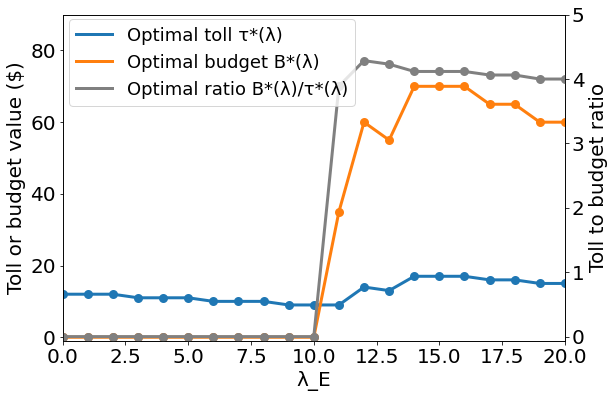

In [45]:
###### Plot optimal CBCP parameters with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].toll,linewidth=3,label='Optimal toll τ*(λ)')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget,linewidth=3,label='Optimal budget B*(λ)')
ax2.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget/this_df.iloc[:21].toll,linewidth=3,label='Optimal ratio B*(λ)/τ*(λ)',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].toll,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget,linewidth=3)
ax2.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].budget/this_df.iloc[:21].toll,linewidth=3,color='grey')

ax1.set_xlabel("λ_E")
ax1.set_ylabel("Toll or budget value ($)")
ax2.set_ylabel('Toll to budget ratio')
fig.legend(bbox_to_anchor=(0.09, 0.02, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax2.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(-1, 90))
ax2.set(xlim=(0,20), ylim=(-0.065, 5))
for label in (ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels()):
    label.set_fontsize(20)
fig.savefig('../plots/plots_budget/OptTollBudget_weight_E_budget.png',bbox_inches='tight')


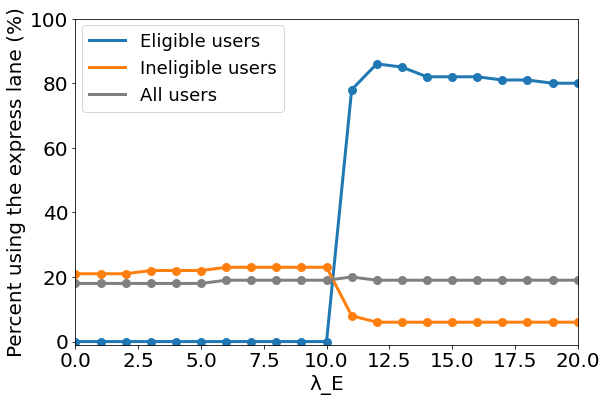

In [46]:
###### Plot optimal CBCP EL usage rates with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_El,linewidth=3,label='Eligible users')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_In,linewidth=3,label='Ineligible users')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_All,linewidth=3,label='All users',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_El,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_In,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].ExpShare_All,linewidth=3,color='grey')
ax1.set_xlabel("λ_E")
ax1.set_ylabel("Percent using the express lane (%)")
fig.legend(bbox_to_anchor=(-0.04, 0.015, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(-1, 100))

for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontsize(20)
fig.savefig('../plots/plots_budget/OptUserShares_weight_E_budget.png',bbox_inches='tight')

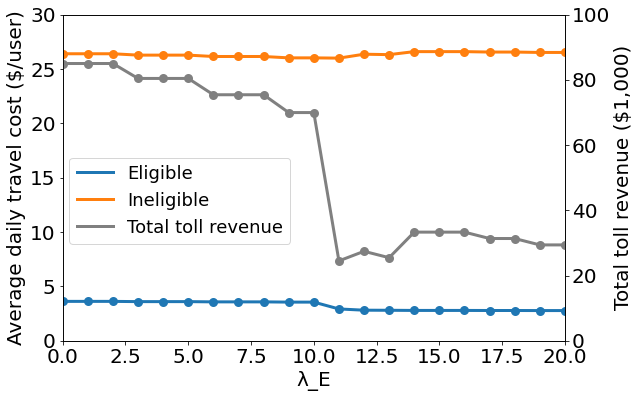

In [47]:
###### Plot optimal CBCP travel cost metrics with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_El/(num_eligible*T),linewidth=3,label='Eligible')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_In/(T*num_ineligible),linewidth=3,label='Ineligible')
ax2.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalTR/1000,linewidth=3,label='Total toll revenue',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_El/(T*num_eligible),linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalGenCost_In/(T*num_ineligible),linewidth=3)
ax2.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].TotalTR/1000,linewidth=3,color='grey')
ax1.set_xlabel("λ_E")
ax1.set_ylabel("Average daily travel cost ($/user)")
ax2.set_ylabel('Total toll revenue ($1,000)')
fig.legend(bbox_to_anchor=(-0.01, -0.3, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax2.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(0, 30))
ax2.set(xlim=(0,20), ylim=(0, 100))
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()+ ax2.get_yticklabels()):
    label.set_fontsize(20) 
fig.savefig('../plots/plots_budget/OptSocialCosts_weight_E_budget.png',bbox_inches='tight')


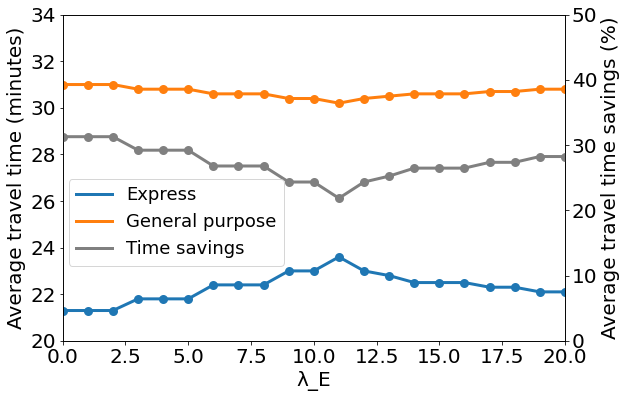

In [48]:


###### Plot optimal CBCP travel times with respect to weigthing scheme ######

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_Express,linewidth=3,label='Express')
ax1.plot(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_GP,linewidth=3,label='General purpose')
ax2.plot(this_df.iloc[:21].weight_e,100*(this_df.iloc[:21].AvgTT_GP-this_df.iloc[:21].AvgTT_Express)/this_df.iloc[:21].AvgTT_GP,linewidth=3,label='Time savings',color='grey')
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_Express,linewidth=3)
ax1.scatter(this_df.iloc[:21].weight_e,this_df.iloc[:21].AvgTT_GP,linewidth=3)
ax2.scatter(this_df.iloc[:21].weight_e,100*(this_df.iloc[:21].AvgTT_GP-this_df.iloc[:21].AvgTT_Express)/this_df.iloc[:21].AvgTT_GP,linewidth=3,color='grey')

ax1.set_xlabel("λ_E")
ax1.set_ylabel("Average travel time (minutes)")
ax2.set_ylabel('Average travel time savings (%)')
fig.legend(bbox_to_anchor=(-0.02, -0.35, 0.5, 0.87),fontsize=18)
fig.set_size_inches(9, 6)
ax1.xaxis.label.set_fontsize(20)
ax1.yaxis.label.set_fontsize(20)
ax2.yaxis.label.set_fontsize(20)
ax1.set(xlim=(0,20), ylim=(20, 34))
ax2.set(xlim=(0,20), ylim=(0, 50))
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()+ ax2.get_yticklabels()):
    label.set_fontsize(20)
fig.savefig('../plots/plots_budget/OptTravelTimes_weight_E_budget.png',bbox_inches='tight')



# Scratch Work:

In [ ]:
# 20*np.linspace(0, 1, 21)[0:]
# np.linspace(toll_arr[0], toll_arr[-3]*T,19)